## Warm-up

In [ ]:
# Check GPU
!nvidia-smi

Sat Jun 18 10:39:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Upgrade fastai
! [ -e /content ] && pip install -Uqq fastai

In [ ]:
# FastAi
from fastai.text.all import *
import fastai

# Extensions
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Check version
fastai.__version__

'2.6.3'

## Original Transfer

In [ ]:
# TMP: tempt data not label, we only focus folder train, test & unsup
# force_download: force overwritten data 
path = untar_data(URLs.IMDB, force_download=True)

# Check folder in path
path.ls()

(#7) [Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/tmp_lm'),Path('/root/.fastai/data/imdb/tmp_clas')]

In [ ]:
# 25000 Data Train with Label Pos & Neg
(path/'train').ls()

(#4) [Path('/root/.fastai/data/imdb/train/labeledBow.feat'),Path('/root/.fastai/data/imdb/train/neg'),Path('/root/.fastai/data/imdb/train/unsupBow.feat'),Path('/root/.fastai/data/imdb/train/pos')]

The data follows an [ImageNet-style organization](https://cloud.google.com/tpu/docs/imagenet-setup), in the train folder, we have two subfolders, `pos` and `neg` (for positive reviews and negative reviews). 

We can gather it by using the `TextDataLoaders.from_folder` method. The only thing we need to specify is the name of the validation folder, which is "test" (and not the default "valid").

In [ ]:
# Gather folders 
dls = TextDataLoaders.from_folder(path, valid="test")

# Show data 
dls.show_batch(max_n = 3)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj this movie was recently released on xxup dvd in the xxup us and i finally got the chance to see this hard - to - find gem . xxmaj it even came with original theatrical previews of other xxmaj italian horror classics like "" xxunk "" and "" beyond xxup the xxup darkness "" . xxmaj unfortunately , the previews were the best thing about this movie . \n\n "" zombi 3 "" in a bizarre way is actually linked to the infamous xxmaj lucio xxmaj fulci "" zombie "" franchise which began in 1979 . xxmaj similarly compared to "" zombie "" , "" zombi 3 "" consists of a threadbare plot and a handful of extremely bad actors that keeps this ' horror ' trash barely afloat . xxmaj the gore is nearly non - existent ( unless one is frightened of people running around with",neg
2,"xxbos xxmaj my xxmaj comments for xxup vivah : - xxmaj its a charming , idealistic love story starring xxmaj shahid xxmaj kapoor and xxmaj amrita xxmaj rao . xxmaj the film takes us back to small pleasures like the bride and bridegroom 's families sleeping on the floor , playing games together , their friendly banter and mutual respect . xxmaj vivah is about the sanctity of marriage and the importance of commitment between two individuals . xxmaj yes , the central romance is naively visualized . xxmaj but the sneaked - in romantic moments between the to - be - married couple and their stubborn resistance to modern courtship games makes you crave for the idealism . xxmaj the film predictably concludes with the marriage and the groom , on the wedding night , tells his new bride who suffers from burn injuries : "" come let me",pos


We can see that the library automatically processed all the texts to split then in *tokens*, adding some special tokens like:

- `xxbos` to indicate the beginning of a text
- `xxmaj` to indicate the next word was capitalized

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a **model pretrained on a bigger dataset - AWDLSTM** (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a **recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.**

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

We use the [AWD LSTM](https://arxiv.org/abs/1708.02182) architecture, `drop_mult` is a parameter that controls the magnitude of all dropouts in that model, and we use `accuracy` to track down how well we are doing. We can then fine-tune our pretrained model:

Then, we can define a `Learner` suitable for text classification in one line:

In [ ]:
# Setup Learner with data loader mix model AWD LSTM with weight pretrain, finetune dropout ratio
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

SuggestedLRs(valley=0.004365158267319202)

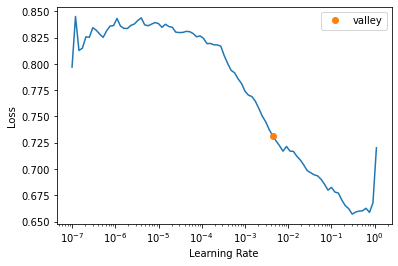

In [ ]:
# Find the optimum learning rate by doing an LR range test
learn.lr_find()

In [ ]:
# Fine-tuning LM (data raw + data pretraining) with 5 epochs & custom learning rate 0.01
# Second bar below meaning percetage of epoches 
learn.fine_tune(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.458992,0.391664,0.823080,02:35


epoch,train_loss,valid_loss,accuracy,time
0,0.304262,0.248489,0.899920,05:40
1,0.241343,0.219613,0.915280,05:42
2,0.217212,0.199994,0.921280,05:41
3,0.159736,0.193199,0.926760,05:42
4,0.112351,0.200539,0.928280,05:41


In [ ]:
# Seeing how well our model doing
learn.show_results(max_n = 3)

,text,category,category_
0,"xxbos xxmaj there 's a sign on xxmaj the xxmaj lost xxmaj highway that says : \n\n * major xxup spoilers xxup ahead * \n\n ( but you already knew that , did n't you ? ) \n\n xxmaj since there 's a great deal of people that apparently did not get the point of this movie , xxmaj i 'd like to contribute my interpretation of why the plot makes perfect sense . xxmaj as others have pointed out , one single viewing of this movie is not sufficient . xxmaj if you have the xxup dvd of xxup md , you can "" cheat "" by looking at xxmaj david xxmaj lynch 's "" top 10 xxmaj hints to xxmaj unlocking xxup md "" ( but only upon second or third viewing , please . ) ;) \n\n xxmaj first of all , xxmaj mulholland xxmaj drive is",pos,pos
1,"xxbos "" the xxmaj moon xxmaj is xxmaj blue "" director xxmaj otto xxmaj preminger tackled even more taboo subject matter in his controversial 1955 release "" the xxmaj man with the xxmaj golden xxmaj arm . "" xxmaj whereas he had incensed the xxmaj motion xxmaj picture xxmaj association of xxmaj america with his use of the words "" virgin "" and "" mistress "" in his mild 1953 comedy "" the xxmaj moon xxmaj is xxmaj blue , "" xxmaj preminger went far beyond what any movie had attempted with "" the xxmaj man with the xxmaj golden xxmaj arm "" since xxmaj dick xxmaj powell made his law and order epic "" to the xxmaj ends of the xxmaj xxunk ) about thwarting the international traffic in narcotics . xxmaj based on xxmaj nelson xxmaj algren 's novel that won the 1950 xxmaj national xxmaj book xxmaj",pos,pos
2,"xxbos i was recently given this film on xxup dvd as a gift , and was unsure at first if it would appeal ( although one of my favourite actors has a leading role ) . xxmaj in fact , it 's on its way to becoming a favourite . \n\n xxmaj first of all : thankfully , it 's * not * the same as the book , the ending of which i think is excessively melodramatic . xxmaj secondly : it 's one of the best films xxmaj i 've seen about the xxmaj first xxmaj world xxmaj war . "" what ? "" you may ask . "" it 's not a war film ! "" xxmaj true : we see no battles or xxunk , no trenches , no gas . xxmaj but it shows the cost of war , the damage done to the lives",pos,pos


In [ ]:
# Predict
learn.predict("I hope Mr Thanh has many lovers for next time")

('pos', TensorText(1), TensorText([0.0137, 0.9863]))

Here we can see the model has considered the review to be positive. The second part of the result is the index of "pos" in our data vocabulary and the last part is the probabilities attributed to each class (99.1% for "pos" and 0.9% for "neg"). 

### Data block API

A datablock is built by giving the fastai library a bunch of information:

- the types used, through an argument called `blocks`: here we have images and categories, so we pass `TextBlock` and `CategoryBlock`. To inform the library our texts are files in a folder, we use the `from_folder` class method.
- how to get the raw items, here our function `get_text_files`.
- how to label those items, here with the parent folder.
- how to split those items, here with the grandparent folder.

In [ ]:
# Blueprint how to assemble data
imdb = DataBlock(blocks=(TextBlock.from_folder(untar_data(URLs.IMDB, force_download=True)), CategoryBlock),
                 get_items = get_text_files,                                 
                 get_y = parent_label,
                 splitter = GrandparentSplitter(valid_name='test'))

In [ ]:
# Create dataloaders with blueprint of datablock 
dls = imdb.dataloaders(path)

## ULMFiT

The pretrained model we used in the previous section is called a **language model. It was pretrained on Wikipedia on the task of guessing the next word, after reading all the words before**. 

We got great results by directly fine-tuning this language model to a movie review classifier, but with one extra step, we can do even better: the Wikipedia English is slightly different from the IMDb English. So instead of jumping directly to the classifier, we could fine-tune our pretrained language model to the IMDb corpus and *then* use that as the base for our classifier.

One reason, of course, is that it is helpful to understand the foundations of the models that you are using. But there is another very practical reason, which is that you get even better results if you fine tune the (sequence-based) language model prior to fine tuning the classification model. 

For instance, in the IMDb sentiment analysis task, the dataset includes 50,000 additional movie reviews that do not have any positive or negative labels attached in the unsup folder. We can use all of these reviews to fine tune the pretrained language model — this will result in a language model that is particularly good at predicting the next word of a movie review. In contrast, the pretrained model was trained only on Wikipedia articles.

![ULMFit process](https://github.com/fastai/fastai/blob/master/nbs/images/ulmfit.png?raw=1)

### Fine-tuning LM on IMDb

Merge Data IMDb to data pretrain, training with task guess next word and after that collect encoder of it.


We can get our texts in a `DataLoaders` suitable for language modeling very easily:

In [ ]:
# path = untar_data(URLs.IMDB, force_download=True)
dls_lm = TextDataLoaders.from_folder(untar_data(URLs.IMDB, force_download=True), is_lm=True, valid_pct=0.1)

We need to pass something for `valid_pct` otherwise this method will try to split the data by using the grandparent folder names. By passing `valid_pct=0.1`, we tell it to get a random 10% of those reviews for the validation set.

We can have a look at our data using `show_batch`. Here the task `is_lm` is to guess the next word, so we can see the targets have all shifted one word to the right.

In [ ]:
dls_lm.show_batch(max_n = 3)

,text,text_
0,xxbos xxmaj the streets of xxmaj paris on a quiet xxmaj sunday morning . xxmaj the shrill scream of a xxmaj ferrari going through the gears . a camera strapped to the hood . xxmaj blasting through red lights at breakneck speed and using pedestrians as apex cones . xxmaj the best 7 minutes of real tv i have ever seen . xxmaj worth every penny for those car nuts and race,xxmaj the streets of xxmaj paris on a quiet xxmaj sunday morning . xxmaj the shrill scream of a xxmaj ferrari going through the gears . a camera strapped to the hood . xxmaj blasting through red lights at breakneck speed and using pedestrians as apex cones . xxmaj the best 7 minutes of real tv i have ever seen . xxmaj worth every penny for those car nuts and race fans
1,"… \n\n xxmaj the film displays corruption as it is happening in xxmaj india , it is very visible , everybody knows who is getting bribed , why they are getting bribed and who is bribing who … … this is quite different from the western world , were bribes are issued but are rarely seen … \n\n xxmaj this film touches on a hard subject rape and i would say paedophilia","\n\n xxmaj the film displays corruption as it is happening in xxmaj india , it is very visible , everybody knows who is getting bribed , why they are getting bribed and who is bribing who … … this is quite different from the western world , were bribes are issued but are rarely seen … \n\n xxmaj this film touches on a hard subject rape and i would say paedophilia …"
2,"the xxmaj wilson xxmaj white xxmaj house to being thrown in jail on false charges , xxmaj alice and xxmaj lucy mean business . xxmaj will they see their fondest dream come true ? xxmaj all women in xxmaj american owe a great debt of thanks to these two brave women and their fellow suffragettes , one that can never be repaid , and this wonderful film tells their story with care","xxmaj wilson xxmaj white xxmaj house to being thrown in jail on false charges , xxmaj alice and xxmaj lucy mean business . xxmaj will they see their fondest dream come true ? xxmaj all women in xxmaj american owe a great debt of thanks to these two brave women and their fellow suffragettes , one that can never be repaid , and this wonderful film tells their story with care and"


Then we have a convenience method to directly grab a `Learner` from it, using the `AWD_LSTM` architecture like before. We use accuracy and perplexity as metrics (the later is the exponential of the loss) and we set a default weight decay of 0.1. 

`to_fp16` puts the [`Learner`](https://docs.fast.ai/text.learner.html) in mixed precision, which is going to help speed up training on GPUs that have Tensor Cores.

In [ ]:
# Load model with pre-trained weight AWD_LSTM & mectrics acc + perplexity
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

**By default, a pretrained `Learner` is in a frozen state, meaning that only the head of the model will train while the body stays frozen.** We show you what is behind the `fine_tune` method here and use a [`fit_one_cycle`](https://fastai1.fast.ai/callbacks.one_cycle.html) method to fit the model:

SuggestedLRs(valley=0.0030199517495930195)

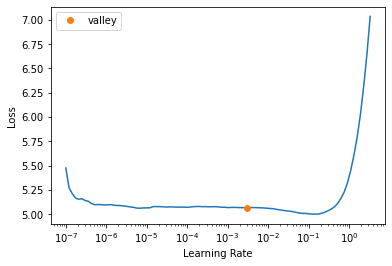

In [ ]:
# LR Range Test Finder 
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.393557,4.112908,0.285870,61.124203,1:33:19


This model takes a while to train, so it's a good opportunity to talk about saving intermediary results. You can easily save the state of your model like so:

In [ ]:
learn.save('tmp_epoch')

Path('/root/.fastai/data/imdb/models/tmp_epoch.pth')

It will create a file in `learn.path/models/` named "1epoch.pth". If you want to load your model on another machine after creating your `Learner` the same way, or resume training later, you can load the content of this file with:

In [ ]:
learn = learn.load('tmp_epoch')

To complete the fine-tuning, we can then [unfeeze](https://forums.fast.ai/t/why-do-we-need-to-unfreeze-the-learner-everytime-before-retarining-even-if-learn-fit-one-cycle-works-fine-without-learn-unfreeze/41614) and launch a new training.

In [ ]:
# Unfrezze and fine-tune it 
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.117709,3.919582,0.304391,50.379387,1:37:22
1,4.043425,3.879955,0.307763,48.422050,1:38:06
2,4.015057,3.861810,0.309546,47.551342,1:39:20
3,4.008782,3.839316,0.312272,46.493668,1:39:51
4,3.966112,3.813732,0.315127,45.319252,1:39:08
5,3.925696,3.787429,0.317942,44.142746,1:41:26
6,3.911512,3.757935,0.321516,42.859840,1:45:57
7,3.836409,3.737130,0.323773,41.977360,1:43:01
8,3.819519,3.721267,0.325974,41.316689,1:43:39
9,3.796437,3.718578,0.326297,41.205772,1:45:01


Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. 

**Encoder**: The model not including the task-specific final layer(s). It means much the same thing as *body* when applied to vision CNNs, but tends to be more used for NLP and generative models. We can save it with `save_encoder`:

In [ ]:
learn.save_encoder('finetuned')

Before using this to fine-tune a classifier on the reviews, we can use our model to generate random reviews: since it's trained to guess what the next word of the sentence is, we can use it to write new reviews:

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

print("\n".join(preds))

i liked this movie because it was a Disney movie . Was it a Disney movie ? It was good , its good to watch , i like the Disney movies , but this movie made me want more !
i liked this movie because Michael Caine was so good . He was great , especially during a no - deal German accent . Also , I 've seen a lot of movies on TV in the past


### Target task classifier fine-tuning

We have to use the exact same vocabulary as when we were fine-tuning our language model, if not the weights learned won't make any sense. We pass that vocabulary with `text_vocab`.

In [ ]:
# Data Loaders
dls_clas = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', text_vocab=dls_lm.vocab)

In [ ]:
# Define text classifier
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [ ]:
# Load fine tune encoder before with LM
learn = learn.load_encoder('finetuned')

The last step is to train with **discriminative learning rates** and **gradual unfreezing**. In computer vision, we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference.

SuggestedLRs(valley=0.002511886414140463)

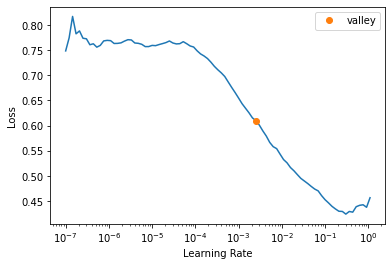

In [ ]:
# LR Range Test
learn.lr_find()

In [ ]:
# Just 1 epoch, get same result as first section
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.221113,0.178494,0.932520,02:36


In [ ]:
# Freeze all except the last two parameters groups
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.205340,0.165981,0.937160,03:03


In [ ]:
# Unfreeze -3 layers 
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.179440,0.152984,0.943720,04:26


In [ ]:
# Unfreeze whole model
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.177308,0.149243,0.943760,05:43
1,0.117044,0.149965,0.945600,05:43
